In [1]:
# basic library
import pandas as pd
import numpy as np
import re
import string
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# model
import torch
from torch.utils.data import DataLoader, TensorDataset

# stop words
%pip install Sastrawi
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# stememer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# nltk corpus
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# tokenizer
from transformers import BertTokenizer
from tokenizers import Tokenizer

# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# other preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# training pipline
import tensorflow as tf
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# label encoding
label_type = ['NotPromotion', 'Promotion']

Note: you may need to restart the kernel to use updated packages.


'unzip' is not recognized as an internal or external command,
operable program or batch file.
c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %load_ext cudf.pandas

# %pip install seaborn
# %pip install Sastrawi
# %pip install wordcloud
# %pip install torch
# %pip install transformers
# %pip install nltk
# %pip install tensorflow
# %pip install gensim --upgrade

In [3]:
combined_data = pd.read_csv('../Dataset/dataset_combined_new - dataset_combined_new.csv', sep=',')
training_data = pd.read_csv('../Dataset/train.csv', sep=',').dropna()
testing_data = pd.read_csv('../Dataset/test.csv', sep=',')
validation_data = pd.read_csv('../Dataset/val.csv')

# training_data = training_data.sample(frac = 1)
training_data.head()

,text,label
0,Mencari pengalaman daring yang lancar? AERO88 ...,1
1,Itu kayanya di kasih tanda deh yg bisa di lewa...,0
2,Whatsapp Telegram Livechat Daftar Login Hdtoto...,1
3,KO SELASA SI BABG,0
4,"TERLEPAS DARI GAME NYA YANG BAGUS, SEMOGA BANG...",0


In [4]:
index = 410
print(training_data.iloc[index, 0])
print([ord(char) for char in training_data.iloc[index, 0]])

Rezeki gak ada putusnya, makasi █▓▒▒░░░PU LAU 777░░░▒▒▓█.
[82, 101, 122, 101, 107, 105, 32, 103, 97, 107, 32, 97, 100, 97, 32, 112, 117, 116, 117, 115, 110, 121, 97, 44, 32, 109, 97, 107, 97, 115, 105, 32, 9608, 9619, 9618, 9618, 9617, 9617, 9617, 80, 85, 32, 76, 65, 85, 32, 55, 55, 55, 9617, 9617, 9617, 9618, 9618, 9619, 9608, 46]


In [5]:
print("train isna:",training_data['text'].isna().sum())
print("test isna:",testing_data['text'].isna().sum())
print("val isna:",validation_data['text'].isna().sum())

print(training_data[training_data['text'].isna()][['text', 'label']])


train isna: 0
test isna: 0
val isna: 0
Empty DataFrame
Columns: [text, label]
Index: []


# Preprocessing

In [6]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
drop_stopwords = ['pula', 'pasti', 'amat', 'ingin', 'sampai']

stopwords += custom_stopwords
stopwords = [word for word in stopwords if word not in drop_stopwords]

pattern = r"[^A-Za-z ]"

print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', 'oh', 'ok', 'seharusnya', 's

In [7]:
def preprocess_text(texts):
    for index, text in enumerate(texts):

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [8]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_val = validation_data['label'].values.copy()
y_test = testing_data['label'].values.copy()

In [9]:
texts_train = preprocess_text(texts_raw_train)
texts_val = preprocess_text(texts_raw_val)
texts_test = preprocess_text(texts_raw_test)

texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

# Tokenization & Vectorizer

In [10]:
# max_len = 50 
# trunc_type = 'post'
# padding_type = 'post'
# oov_tok = '<OOV>'
# vocab_size = 500

In [12]:
# gpt2 tokenizer

tokenizer = Tokenizer.from_pretrained("gpt2")
encoded_texts_train = [tokenizer.encode(text).ids for text in texts_train]
encoded_texts_test = [tokenizer.encode(text).ids for text in texts_test]

In [11]:
# indobert tokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

## Add New Tokens

In [57]:
a = list(tokenizer.vocab.keys())
print(a,'\n')
print(texts_train[410].split(' '))
print(tokenizer.tokenize(texts_train[410]))

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##an', 'd', '##er', 'm', '##en', 's', 'p', '##ar', 'b', 'k', '##at', '##ang', '##in', 't', '##ak', '##al', '##ah', '##as', '##un', '##am', '##em', 'di', '##ya', '##el', '##ad', '##eng', 'y', '##kan', '##tu', 'yang', 'se', '##ap', '##is', 'l', '##ik', 'h', 'dan', 'j', 'ke', '##il', 'men', '##on', '##it', 'in', 'ber', '##us', '##ga', '##or', '##es', 'ter', '##ing', 'r', '##nya', '##ur', '##akan', 'mem', 'c', 'per', '##ut', '##id', '##ari', '##ul', '##um', 'n', '##ada', '##uk', '##ek', '##ir', '##ol', '##ih', '##engan', '##ung', '##eb', 'un', 'dengan', 'meng', '##tuk', '##ag', 'g', '##et', '##ara', '##and', '##ti', '##au', 'i', 'untuk', '##asi', 'ini', '##alam', '##ai', '##im', '##ba', 'pen', 'dari', '##ud', 'w', '##om', '##ia', '##alah', '##ab', '##ot', '##si', '##aj', 'f', '2', '##up', '1', 'dalam', 'pr', 'tid', '##bu', '##ama', 'at', '##ok', 'tidak', 'ad', '##ian', '##aw', '##ain', '##anya', '##per', 'pada', 'pem', '##aya', '##adi', '##ak

In [13]:
custom_tokens = [
    '##pu##',
    'lau',
    '##777##',
    'pu',
    'Pulau777', 'WISDOMTOTO', 'bonus', 'Jackpot', 'gacor', 'situ', 'hari', 'slot', 'AERO88', 'Olympus', 'FREEBET', '100RB', 'TRY', 'Home Draw', 'Draw Away', 'main AERO88', 'Gate', 'Deposit', 'Pragmatic Play', 'HOT', 'P U', 'U L', 'DEWADOЯA', 'Wins Black', 'DEWADОRA', 'HO KI', 'jepe', 'member', 'Play homeHotGame', 'DEWADORA', 'agoIDR', 'RU DA', 'cuan', 'Microgaming', 'hoki', 'Hokidewa', 'D3WADOR4', 'homeHotGame', 'Lucky Twins', 'teman teman', 'KETIK DI', 'Spadegaming', 'DEWADORА', 'Pulαυ777', 'fire 𝗱𝟯𝗣𝟬', '𝗱𝟯𝗣𝟬 j𝗱', 'j𝗱 𝟮𝗷𝘁', '𝟮𝗷𝘁','𝗚𝗔𝗥𝗔𝗡𝗦𝗜', '𝗠𝗘𝗧𝗘𝗢𝗥𝗪𝗜𝗡', 'Joker', 'JP', 'SaktiSpin', 'gacir', 'DEWАDORA', 'Poinbet', 'MAXWIN', '168wbtoto', 'AE RO88', 'DEWAD0R4', 'tuh',
    '░▒▓', '░░', '▒','█'
]

keywords = ['pulau']

# for i in range(len(texts_train)):
#     sentences = texts_train[i]
#     words = sentences.split()
#     if words in keywords:
#         custom_tokens.extend(words)

print(custom_tokens)

['##pu##', 'lau', '##777##', 'pu', 'Pulau777', 'WISDOMTOTO', 'bonus', 'Jackpot', 'gacor', 'situ', 'hari', 'slot', 'AERO88', 'Olympus', 'FREEBET', '100RB', 'TRY', 'Home Draw', 'Draw Away', 'main AERO88', 'Gate', 'Deposit', 'Pragmatic Play', 'HOT', 'P U', 'U L', 'DEWADOЯA', 'Wins Black', 'DEWADОRA', 'HO KI', 'jepe', 'member', 'Play homeHotGame', 'DEWADORA', 'agoIDR', 'RU DA', 'cuan', 'Microgaming', 'hoki', 'Hokidewa', 'D3WADOR4', 'homeHotGame', 'Lucky Twins', 'teman teman', 'KETIK DI', 'Spadegaming', 'DEWADORА', 'Pulαυ777', 'fire 𝗱𝟯𝗣𝟬', '𝗱𝟯𝗣𝟬 j𝗱', 'j𝗱 𝟮𝗷𝘁', '𝟮𝗷𝘁', '𝗚𝗔𝗥𝗔𝗡𝗦𝗜', '𝗠𝗘𝗧𝗘𝗢𝗥𝗪𝗜𝗡', 'Joker', 'JP', 'SaktiSpin', 'gacir', 'DEWАDORA', 'Poinbet', 'MAXWIN', '168wbtoto', 'AE RO88', 'DEWAD0R4', 'tuh', '░▒▓', '░░', '▒', '█']


In [14]:
print('len tokenizer vocabs:', len(set(tokenizer.vocab.keys())))

len tokenizer vocabs: 30521


In [15]:
original_tokens = tokenizer.vocab.keys()

new_tokens = set(custom_tokens) - set(original_tokens)
print("len new custom tokens:", len(new_tokens))

len new custom tokens: 59


In [16]:
new_tokens = {"additional_special_tokens" :custom_tokens}
# new_tokens

In [101]:
with open("new_tokens.txt", "w") as file:
    for item in new_tokens:
        file.write(f"{item}\n")

In [17]:
total_tokens = len(new_tokens) + len(original_tokens)
total_tokens

30522

In [18]:
# new_tokensz = {'additional_special_tokens': [new_tokens['additional_special_tokens'][0], '##█▓▒▒░░░##', '##░░░▒▒▓█##']}
# new_tokensz

In [19]:
# Add new custom tokens

tokenizer.add_special_tokens(new_tokens)

59

In [ ]:
# Add new custom tokens

num_added_toks = tokenizer.add_tokens(custom_tokens, special_tokens=True)
print(num_added_toks)
# model.resize_token_embeddings(len(tokenizer))

('../Tokenizer/custom_indobert_tokenizer\\tokenizer_config.json',
 '../Tokenizer/custom_indobert_tokenizer\\special_tokens_map.json',
 '../Tokenizer/custom_indobert_tokenizer\\vocab.txt',
 '../Tokenizer/custom_indobert_tokenizer\\added_tokens.json')

In [23]:
# save custom tokenizer

tokenizer.save_pretrained("../Tokenizer/custom_indobert_tokenizer")

('../Tokenizer/custom_indobert_tokenizer\\tokenizer_config.json',
 '../Tokenizer/custom_indobert_tokenizer\\special_tokens_map.json',
 '../Tokenizer/custom_indobert_tokenizer\\vocab.txt',
 '../Tokenizer/custom_indobert_tokenizer\\added_tokens.json')

In [24]:
tokenizer = BertTokenizer.from_pretrained('../Tokenizer/custom_indobert_tokenizer')

In [20]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'additional_special_tokens': ['##pu##',
  'lau',
  '##777##',
  'pu',
  'Pulau777',
  'WISDOMTOTO',
  'bonus',
  'Jackpot',
  'gacor',
  'situ',
  'hari',
  'slot',
  'AERO88',
  'Olympus',
  'FREEBET',
  '100RB',
  'TRY',
  'Home Draw',
  'Draw Away',
  'main AERO88',
  'Gate',
  'Deposit',
  'Pragmatic Play',
  'HOT',
  'P U',
  'U L',
  'DEWADOЯA',
  'Wins Black',
  'DEWADОRA',
  'HO KI',
  'jepe',
  'member',
  'Play homeHotGame',
  'DEWADORA',
  'agoIDR',
  'RU DA',
  'cuan',
  'Microgaming',
  'hoki',
  'Hokidewa',
  'D3WADOR4',
  'homeHotGame',
  'Lucky Twins',
  'teman teman',
  'KETIK DI',
  'Spadegaming',
  'DEWADORА',
  'Pulαυ777',
  'fire 𝗱𝟯𝗣𝟬',
  '𝗱𝟯𝗣𝟬 j𝗱',
  'j𝗱 𝟮𝗷𝘁',
  '𝟮𝗷𝘁',
  '𝗚𝗔𝗥𝗔𝗡𝗦𝗜',
  '𝗠𝗘𝗧𝗘𝗢𝗥𝗪𝗜𝗡',
  'Joker',
  'JP',
  'SaktiSpin',
  'gacir',
  'DEWАDORA',
  'Poinbet',
  'MAXWIN',
  '168wbtoto',
  'AE RO88',
  'DEWAD0R4',
  'tuh',
  '░▒▓',
  '░░',
  

In [21]:
texts_train[410]

'Rezeki gak putusnya , makasi █▓▒▒░░░PU LAU 777░░░▒▒▓█ .'

In [22]:
print(tokenizer.tokenize(texts_train[410]))
print(tokenizer.tokenize("diamsama denganDEWADORАanjing"))

['rezeki', 'gak', 'pu', 'tus', '##nya', ',', 'makasi', '█', '[UNK]', '▒', '▒', '░░', '[UNK]', 'U L', 'au', '77', '##7', '░░', '[UNK]', '█', '.']
['diam', '##sama', 'dengan', 'DEWADORА', 'anjing']


## Apply Tokenization

In [24]:
# for bert tokenizer
train_inputs = tokenizer(texts_train.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
train_inputs = {key: tf.convert_to_tensor(value) for key, value in train_inputs.items()}
train_encodings = tf.data.Dataset.from_tensor_slices((
    train_inputs['input_ids'],
    y_train
)).batch(16) 

val_inputs = tokenizer(texts_val.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
val_inputs = {key: tf.convert_to_tensor(value) for key, value in val_inputs.items()}
val_encodings = tf.data.Dataset.from_tensor_slices((
    val_inputs['input_ids'],
    y_val
)).batch(16)

test_inputs = tokenizer(texts_test.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
test_inputs = {key: tf.convert_to_tensor(value) for key, value in test_inputs.items()}
test_encodings = tf.data.Dataset.from_tensor_slices((
    test_inputs['input_ids'],
    y_test
)).batch(16)

In [287]:
def tokenize_function(texts, token=None):
    if token == 'bert':
        inputs = tokenizer(texts_train.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)
        return inputs['input_ids']
    
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=512)


In [ ]:
# for other tokenization
# train_encodings = tokenize_function(texts_train.tolist())
# test_encodings = tokenize_function(texts_test.tolist())
# validation_encodings = tokenize_function(texts_val.tolist())

train_encodings = tokenize_function(texts_train.tolist(), "bert")
test_encodings = tokenize_function(texts_test.tolist(), "bert")
val_encodings = tokenize_function(texts_val.tolist(), "bert")

In [259]:
# pad sequence
max_len = 50 
trunc_type = 'post'
padding_type = 'post'

# training_sequences = tokenizer.texts_to_sequences(X_train) #tokenize
X_train = pad_sequences(encoded_texts_train,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

X_test = pad_sequences(encoded_texts_test,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

print('Shape of training tensor: ', X_train.shape)
print('Shape of testing tensor: ', X_test.shape)

Shape of training tensor:  (2736, 50)
Shape of testing tensor:  (342, 50)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(texts_padded, labels, test_size=0.1, stratify=labels)

In [268]:
print(texts_train[1])
print(X_train[1])

Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru


# Training

In [25]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define parameter
drop_value = 0.2
# n_dense = 24
# vocab_size = tokenizer.get_vocab_size() + 1 # +1 for padding token
vocab_size = len(tokenizer)
embedding_dim = 256

print("vocab size:",vocab_size)

vocab size: 30580


In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim))
# model.add(GlobalAveragePooling1D())
model.add(SpatialDropout1D(drop_value))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

# Fully connected layers
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

checkpoint_callback = ModelCheckpoint(filepath='./best_model_checkpoint.keras',  
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=False,  # Save full model (architecture + weights)
                                      verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

num_epochs = 12
# history = model.fit(train_encodings,
#                     y_train,
#                     epochs=num_epochs, 
#                     batch_size=16,
#                     validation_data=(validation_encodings, y_val),
#                     callbacks =[checkpoint_callback],
#                     class_weight=class_weights
#                     )

history = model.fit(
    train_encodings,
    validation_data=val_encodings,
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
    class_weight=class_weights
)
                    

Epoch 1/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5519 - loss: 1.2945
Epoch 1: val_accuracy improved from -inf to 0.70845, saving model to ./best_model_checkpoint.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 69s 308ms/step - accuracy: 0.5522 - loss: 1.2943 - val_accuracy: 0.7085 - val_loss: 1.1873
Epoch 2/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5867 - loss: 1.1646
Epoch 2: val_accuracy did not improve from 0.70845
171/171 ━━━━━━━━━━━━━━━━━━━━ 52s 304ms/step - accuracy: 0.5869 - loss: 1.1644 - val_accuracy: 0.6064 - val_loss: 1.0949
Epoch 3/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6387 - loss: 1.0474
Epoch 3: val_accuracy improved from 0.70845 to 0.72886, saving model to ./best_model_checkpoint.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 322ms/step - accuracy: 0.6390 - loss: 1.0472 - val_accuracy: 0.7289 - val_loss: 0.9568
Epoch 4/12
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7591 - loss: 0.8964
Epoch 4: val_accuracy improved from 

In [60]:
model.save("../Model/LSTM_INDOBERT_CUSTOM.h5")

# Eval

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("../Model/LSTM_INDOBERT_CUSTOM.h5")

In [61]:
model.evaluate(test_encodings, verbose=0)


[0.24604317545890808, 0.9824561476707458]

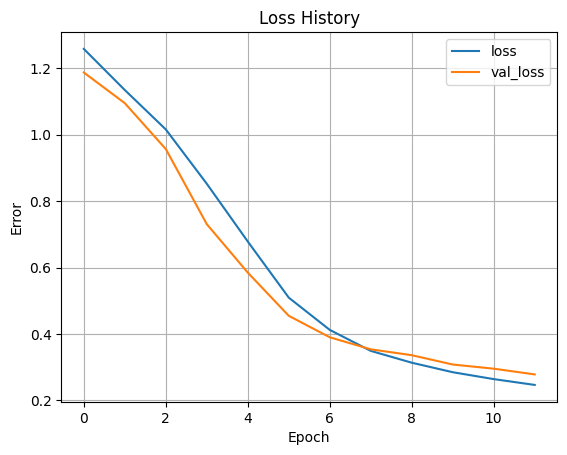

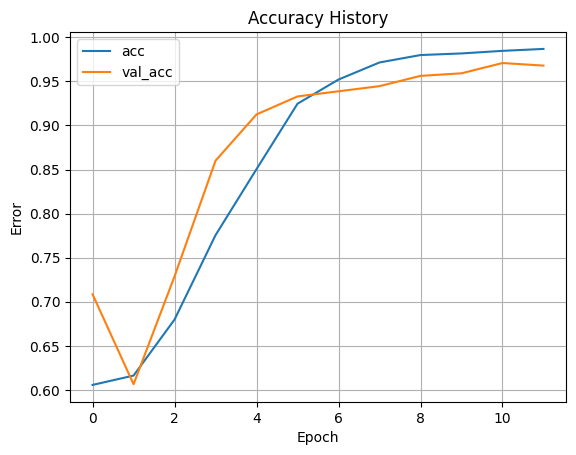

In [30]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title("Loss History")
plt.show()

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title("Accuracy History")
plt.grid(True)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
Accuracy Score: 0.9824561403508771
F1 Score: 0.967391304347826
Recall Score: 0.967391304347826
Precision Score: 0.967391304347826
Classification Report: 
              precision    recall  f1-score   support

NotPromotion       0.99      0.99      0.99       250
   Promotion       0.97      0.97      0.97        92

    accuracy                           0.98       342
   macro avg       0.98      0.98      0.98       342
weighted avg       0.98      0.98      0.98       342

Confusion Matrix:



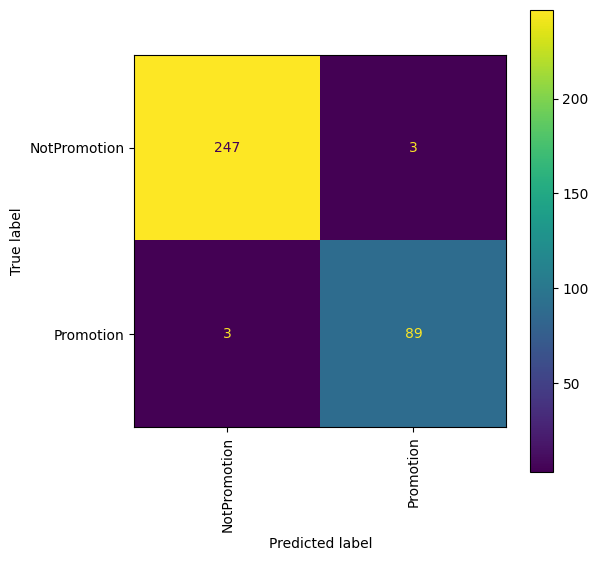

In [62]:
pred = model.predict(test_encodings)
y_pred = [0 if pred < 0.5 else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(y_pred, y_test)}")
print(f"F1 Score: {f1_score(y_pred, y_test)}")
print(f"Recall Score: {recall_score(y_pred, y_test)}")
print(f"Precision Score: {precision_score(y_pred, y_test)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(6,6))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [33]:
for idx,i in enumerate(y_pred):
    if i != y_test[idx]:
        print("***",idx+1,"| pred:", i, "| label:", y_test[idx], texts_test[idx])
        continue
    print(idx+1,"| pred:", i, "| label:", y_test[idx], texts_test[idx])

1 | pred: 1 | label: 1 INFO CINA777APK CINA777RTP CINA777Logo24/11/2024 ( Min ) 14.56 ( GMT+07 ) Versi MobileVersi WAP ( NEX4D ) Nama PenggunaKata SandiLupa Kata Sandi ? DaftarHomeTogelHot GamesSlotsLive CasinoOlahragaCrash GameArcadePokerE-SportsSabung AyamPromosiWelcome to situs resmi CINA777 | Kami membayar berapapun kemenangan player.HasilPasaranBuku MimpiHasil TerakhirStatistik MarketGame PopulerMahjong Wins 3 – Black ScatterMAINMahjong Wins 3 – Black ScatterMahjong WaysMAINMahjong WaysMighty HerculesMAINMighty HerculesSlot88 BonanzaMAINSlot88 BonanzaLe PharaohMAINLe PharaohPirate Quest 1000MAINPirate Quest 1000SixSixSixMAINSixSixSixWay of NinjaMAINWay of Ninja888 GoldMAIN888 GoldMahjong Ways 2MAINMahjong Ways 2Gates of Olympus 1000™MAINGates of Olympus 1000™Wild Bounty ShowdownMAINWild Bounty ShowdownLucky Twins NexusMAINLucky Twins NexusNexus Koi GateMAINNexus Koi GateThe CryptMAINThe CryptLucky Twins Power ClustersMAINLucky Twins Power ClustersMentalMAINMentalFortune Gems 2MAIN

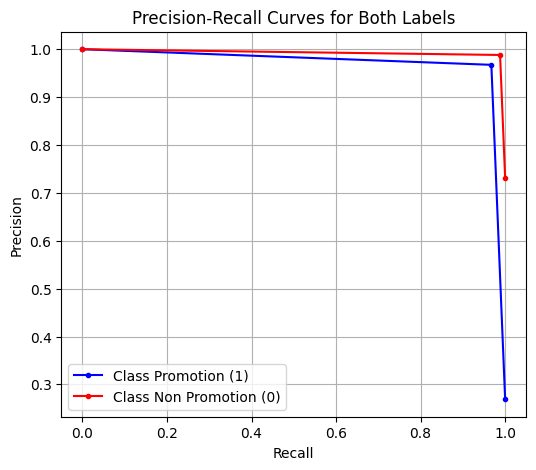

In [35]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall values for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred)

# Compute precision-recall values for class 0 (negative class)
y_scores_neg = 1 - np.array(y_pred)  # Since model predicts class 1 probabilities, class 0 is (1 - probability)
precision_0, recall_0, _ = precision_recall_curve(1 - y_test, y_scores_neg)

# Plot Precision-Recall curves for both classes
plt.figure(figsize=(6, 5))
plt.plot(recall_1, precision_1, marker='.', label=f'Class Promotion (1)', color='blue')
plt.plot(recall_0, precision_0, marker='.', label=f'Class Non Promotion (0)', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Both Labels')
plt.legend()
plt.grid()
plt.show()

In [59]:
def predict_sentiment(text):
    # use_text = preprocess_text(text)
    # # use_text = tokenizer.texts_to_sequences(use_text)
    # # use_text = [tokenizer.encode(text).ids for text in use_text]
    
    # # use_text_padded = pad_sequences(use_text,
    # #                            maxlen = max_len,
    # #                            padding = padding_type,
    # #                            truncating = trunc_type)
    
    # use_text = tokenizer(use_text, padding=True, truncation=True, return_tensors='tf', max_length=512)
    # use_text = {key: tf.convert_to_tensor(value) for key, value in use_text.items()}
    # use_text = tf.data.Dataset.from_tensor_slices((
    #     use_text['input_ids']
    # )).batch(16)

    use_text = preprocess_text(text)
    inputs = tokenizer(use_text, padding=True, truncation=True, return_tensors='tf', max_length=512)
    use_text = inputs['input_ids']
    use_text = tf.keras.preprocessing.sequence.pad_sequences(use_text, maxlen=512, padding="post")

    pred = model.predict(use_text)
    # pred_labels = tf.argmax(pred, axis=1)
    pred_labels = [0 if pred < 0.5 else 1 for pred in pred]
    # print(pred)
 
    pred_labels = [label_type[label] for label in pred_labels]
    for index, preds in enumerate(pred_labels):
        print(f"{text[index]}: {preds}")
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs    yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.",
    "dapatkan banyak rejekii di DEWADORА!"
]
predict_sentiment(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Aku seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial , Cak Imin : 8,8 Juta Pasien Minta Direhabilitasi Jumat , 15 Nov: NotPromotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang xxtoto: Promotion
top up kantorbola pasti gampang menangnya: Promotion
gratis koin buruan topup agencasinoindonesia: Promotion
gratis koin buruan topup fairbet88.com , segera daftarkan akun: Promotion
DEWA-DORA tuh situs paling enak withdraw tiap hari ! 😖 😣: Promotion
DEWA-DORA tuh situs paling gampang narik tiap hari ! 😖 😣: Promotion
Gua setia maen DEWADORA , tempat terbaik !: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung Menang berapapun dibayar .: Promotion
dapatkan banyak rejekii DEWADORА !: Promotion
